# Topic Modelling

In [38]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import glob
import gensim
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import tqdm
import nltk
import re
from operator import itemgetter
import time
from pprint import pprint

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
def preprocess_text(sentence):
    # Lowercase
    sentence = sentence.lower()
    
    # Remove all non-alphabets (punctuation, numbers, new-line characters and extra-spaces)
    sentence = re.sub(r'[^a-zA-Z]+', ' ', sentence)
    sentence = sentence.replace('\n', '')
    # Remove URLs
    sentence = re.sub(r'https\S+', '', sentence)
    # Remove double spacing
    sentence = re.sub('\s+', ' ', sentence)
    
    # Tokenize & remove stop-words
    word_list = nltk.word_tokenize(sentence)    
    stopwords_list = nltk.corpus.stopwords.words('english')
    stopwords_list.extend(['thank','today','join','astrazeneca','pfizer','biogen','johnson','amp','gsk','jnj','lt'])
    word_list = [word for word in word_list if word not in stopwords_list]
    
    # Remove very small words, length < 3, they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 3]
        
    # Stem & Lemmatize
    porter_stemmer = nltk.stem.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    word_list = [porter_stemmer.stem(word) for word in word_list]
    word_list = [lemmatizer.lemmatize(word) for word in word_list]
    
    sentence = ' '.join(word_list)
    
    return sentence

In [ ]:
# Constants
file1 = '/content/drive/MyDrive/Project 2/data/pharma_companies/'+'pfizer'+'.csv'
file2 = '/content/drive/MyDrive/Project 2/data/pharma_companies/'+'Merck'+'.csv'
file3 = '/content/drive/MyDrive/Project 2/data/pharma_companies/'+'JNJNews'+'.csv'
file4 = '/content/drive/MyDrive/Project 2/data/pharma_companies/'+'LillyPad'+'.csv'
file5 = '/content/drive/MyDrive/Project 2/data/pharma_companies/'+'abbvie'+'.csv'
df = pd.concat(
map(pd.read_csv, [file1, file2, file3, file4, file5]), ignore_index=True)

# PHARMA_PATH = '../../data/twitter/pharma companies'
# GOVT_INSTITUTES_PATH = '../../data/twitter/govt institutes'
# NGO_PATH = '/content/drive/MyDrive/Project 2/data/ngo_who/'+'WHO'+'.csv'

EPOCHS = 205
TOPICS = 5
CHUNK_SIZE = 1000
WORKERS = 7
EVAL_PERIOD = 10
ALPHA = 0.01
BETA = 0.9

In [ ]:

print(df.shape)

(11546, 13)


In [ ]:
# Convert 'created_at' column to datetime
df['created_at'] = df['created_at'].str[:-6]
df['created_at'] = pd.to_datetime(df['created_at'])

# Sort by datetime ascending
df = df.sort_values(by='created_at')

# Pre-process the dataset
tqdm.tqdm.pandas()
df['tweet_tokenized'] = df['tweet'].progress_apply(lambda x:preprocess_text(str(x)))

100%|██████████| 11546/11546 [00:15<00:00, 743.12it/s]


Generate TF-IDF

In [ ]:
documents = df['tweet_tokenized'].str.split()
dictionary = gensim.corpora.Dictionary(documents)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)

tfidf_model = gensim.models.TfidfModel(dictionary=dictionary)

corpus = [dictionary.doc2bow(d) for d in documents]
corpus_tfidf = list(tfidf_model[corpus])
performance_metrics = pd.DataFrame(columns=['feature-extraction','clustering-algo','run#', 'state', 'c_v', 'c_umass','topics','time'])

LDA

In [ ]:
for run, state in zip(range(2, 3, 1), range(4, 6, 2)):
    print('Run #', run)
    
    start = time.time()
    gensim_lda = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf, num_topics=TOPICS, id2word=dictionary, chunksize=CHUNK_SIZE, passes=EPOCHS, 
                                                     eval_every = EVAL_PERIOD, per_word_topics=True, random_state=state, alpha=ALPHA, eta=BETA)
    
    coherence_cv = gensim.models.CoherenceModel(model=gensim_lda, texts=documents, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_cumass = gensim.models.CoherenceModel(model=gensim_lda, texts=documents, dictionary=dictionary, coherence='u_mass').get_coherence()
    topics = gensim_lda.print_topics()
    
    stop = time.time()
    
    performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'LDA', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,
                                                      'topics':topics,'time':(stop-start)}, ignore_index=True)

Run # 2


<ipython-input-15-0fc48290541a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'LDA', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,


NMF

In [ ]:
for run, state in zip(range(1, 2, 1), range(2, 4, 2)):
    print('Run #', run)
    
    start = time.time()
    gensim_nmf = gensim.models.Nmf(corpus=corpus_tfidf, num_topics=TOPICS, id2word=dictionary, chunksize=CHUNK_SIZE, passes=EPOCHS, eval_every=EVAL_PERIOD, minimum_probability=0, 
                                   random_state=state, kappa=1)
    
    coherence_cv = gensim.models.CoherenceModel(model=gensim_nmf, texts=documents, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_cumass = gensim.models.CoherenceModel(model=gensim_nmf, texts=documents, dictionary=dictionary, coherence='u_mass').get_coherence()
    topics = gensim_nmf.print_topics()
    
    stop = time.time()
    
    performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'NMF', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,
                                                      'topics':topics,'time':(stop-start)}, ignore_index=True)

Run # 1


<ipython-input-17-5c68f8286f4d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'NMF', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,


LSI

In [ ]:
for run, state in zip(range(1, 2, 1), range(2, 4, 2)):
    print('Run #', run)
    
    start = time.time()
    gensim_lsi = gensim.models.LsiModel(corpus=corpus_tfidf, num_topics=TOPICS, id2word=dictionary, chunksize=CHUNK_SIZE)
    
    coherence_cv = gensim.models.CoherenceModel(model=gensim_lsi, texts=documents, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_cumass = gensim.models.CoherenceModel(model=gensim_lsi, texts=documents, dictionary=dictionary, coherence='u_mass').get_coherence()
    topics = gensim_lsi.print_topics()
    stop = time.time()
      
    performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'LSI', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,
                                                      'topics':topics,'time':(stop-start)}, ignore_index=True)

Run # 1


<ipython-input-19-88e3d624a2bc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'LSI', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,


HDP

In [ ]:
for run, state in zip(range(1, 2, 1), range(2, 4, 2)):
    print('Run #', run)
    
    start = time.time()
    gensim_hdp = gensim.models.hdpmodel.HdpModel(corpus=corpus_tfidf, id2word=dictionary, chunksize=CHUNK_SIZE, random_state=state, kappa=1, alpha=ALPHA)
    
    coherence_cv = gensim.models.CoherenceModel(model=gensim_hdp, texts=documents, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_cumass = gensim.models.CoherenceModel(model=gensim_hdp, texts=documents, dictionary=dictionary, coherence='u_mass').get_coherence()
    topics = gensim_hdp.print_topics()
    stop = time.time()
      
    performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'HDP', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,
                                                      'topics':topics,'time':(stop-start)}, ignore_index=True)

Run # 1


<ipython-input-21-b61ff710b833>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'HDP', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,


In [ ]:
performance_metrics.to_csv('/content/drive/MyDrive/Project 2/results/content-analysis/topic-modelling/pharma-lda-nmf-lsi-hdp.csv',index=False)

# Topic Propagation

In [ ]:
import glob
import numpy as np
import pandas as pd
import re
import ast

In [ ]:
topic_df = pd.read_csv('/content/drive/MyDrive/Project 2/results/content-analysis/topic-keywords/topic-keywords-pharma.csv')

In [ ]:
def isPhraseIn(phrase, text):
    '''
    Returns a boolean value testifying if the phrase exists in the tweet
    '''
    return re.search(r"\b{}\b".format(phrase), text, re.IGNORECASE) is not None

In [ ]:
user_topic_df = pd.DataFrame(columns=['username','topic','tweetCount'])
GOVT_INSTITUTES_PATH = '/content/drive/MyDrive/Project 2/data/pharma_companies'
for file in glob.glob(GOVT_INSTITUTES_PATH + "/*.csv"):
    user_df = pd.read_csv(file)
    username = user_df['username'].unique()[0]
    
   
    print('='*100)
    print('2020-2022: ', username)
    for topic_index, topic_row in topic_df[topic_df['time-phase']=='X'].iterrows():
        topic = topic_row['topic']
        # print(topic)
        keywords = ast.literal_eval(topic_row['topic-keywords'])
        # print(keywords)
        topic_user_tweet_count = 0
        
        for index, row in user_df.iterrows():
            for phrase in keywords:
                # print(phrase)
                if(isinstance(row.tweet, float)):
                    row.tweet = str(row.tweet)
                if phrase in row.tweet:                    
                    topic_user_tweet_count += 1
        
        print(topic, topic_user_tweet_count)
        
        user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
    
# pre_covid_topic_df.to_csv('pre-covid-pharma-companies.csv', index=False)
user_topic_df.to_csv('topic-propagation-pharma.csv', index=False)

2020-2022:  AstraZeneca
Communication 0
Health announcements 9


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Community Healthcare 393
World Regions 16


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


COVID-19 97


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


2020-2022:  GSK
Communication 2


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Health announcements 106


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Community Healthcare 317
World Regions 10


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


COVID-19 344


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


2020-2022:  Novartis
Communication 0


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Health announcements 10
Community Healthcare 23
World Regions 6


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


COVID-19 26


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


2020-2022:  pfizer
Communication 8


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Health announcements 17


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Community Healthcare 450


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


World Regions 27


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


COVID-19 551


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


2020-2022:  JNJNews
Communication 3


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Health announcements 42


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Community Healthcare 162


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


World Regions 23


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


COVID-19 393


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


2020-2022:  Merck
Communication 3


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Health announcements 14
Community Healthcare 450
World Regions 8


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


COVID-19 145


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


2020-2022:  LillyPad
Communication 8


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Health announcements 5
Community Healthcare 73
World Regions 14


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


COVID-19 36


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


2020-2022:  abbvie
Communication 2


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Health announcements 23
Community Healthcare 188
World Regions 13


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


COVID-19 70


<ipython-input-12-8aedf7005773>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


# Heatmaps

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing
import seaborn as sns
import textwrap

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project 2/results/content-analysis/topic-propagation/topic-propagation-pharma.csv')
df.set_index('Org', inplace=True)

In [ ]:
df

Communication  Health announcements  Community Health  \
Org                                                               
pfizer                8                    17               450   
JNJNews               3                    42               162   
Merck                 3                    14               450   
LillyPad              8                     5                73   
abbvie                2                    23               188   

          World Regions  COVID-19  
Org                                
pfizer               27       551  
JNJNews              23       393  
Merck                 8       145  
LillyPad             14        36  
abbvie               13        70

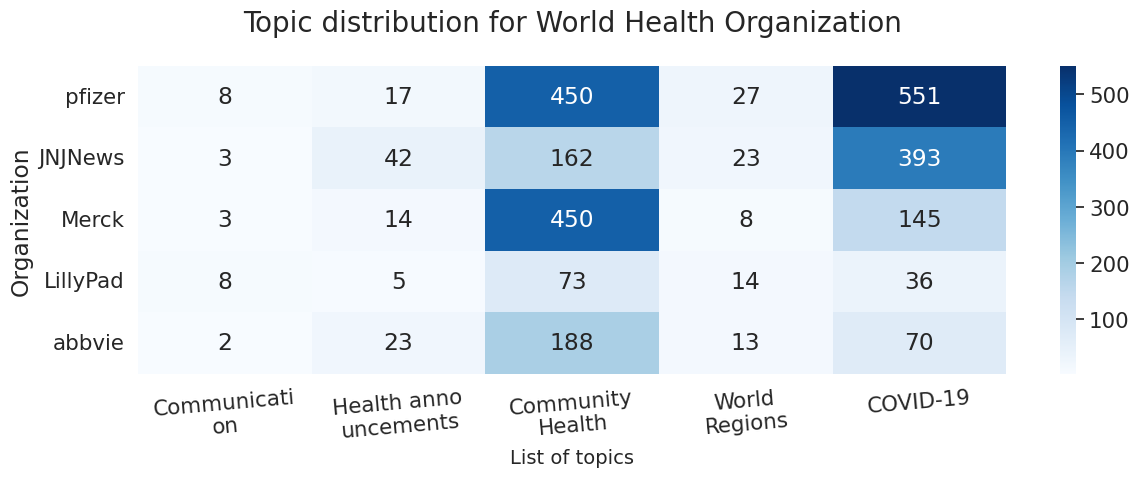

In [ ]:
plt.figure(figsize = (14,4))
plt.rcParams['axes.titlepad'] = 25
sns.set(font_scale=1.4)

# ax = sns.heatmap(df, annot=True, cmap='Blues',fmt='g')
ax = sns.heatmap(df, annot=True, cmap='Blues', fmt='g')
plt.title('Topic distribution for World Health Organization', fontdict={'fontsize':20})
plt.xlabel('List of topics')
plt.ylabel('Organization')
ax.xaxis.label.set_size(14)
ax.set_xticklabels(textwrap.fill(x.get_text(), 11) for x in ax.get_xticklabels())
plt.xticks(rotation=5)
plt.savefig('pharmaceutical-companies.pdf', transparent=True, bbox_inches='tight')
plt.savefig('pharmaceutical-companies.png', transparent=True, bbox_inches='tight')
plt.show()

# Hashtags & Mentions

In [ ]:
!pip install advertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.1/310.1 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.9/272.9 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 9.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import glob
import gensim
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import tqdm
import nltk
import re
from operator import itemgetter
import time
import advertools as adv
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def remove_tags(tweet):
    return re.sub('#dyk|#hcv|#unsubscribe','',tweet)

In [ ]:
def hashtags(data,column):
    hashtag_summary = adv.extract_hashtags(data[column].astype('str').values.tolist()) 
    # print(hashtag_summary['top_hashtags'][:10]][::-1])   
    plt.figure(figsize=(14, 6))
    plt.barh([x[0] for x in hashtag_summary['top_hashtags'][:10]][::-1],
         [x[1] for x in hashtag_summary['top_hashtags'][:10]][::-1])
    plt.title('Top Hashtags for {}'.format(data.name))
    plt.show()
    print(hashtag_summary['top_hashtags'][:10])
    return print("hashtag_overview:",hashtag_summary['overview'])
    
def mentions(data,column):
  mention_summary = adv.extract_mentions(data[column].astype('str').values.tolist())
  plt.figure(figsize=(15,6))
  plt.barh([x[0] for x in mention_summary['top_mentions'][:10]][::-1],
        [x[1] for x in mention_summary['top_mentions'][:10]][::-1])
  plt.title('Top Mentions for {}'.format(data.name))
  plt.show()
  print(mention_summary['top_mentions'][:10])
  return print("overview:",mention_summary['overview'])

In [ ]:
PATH = '/content/drive/MyDrive/Project 2/data/pharma_companies'

In [ ]:
pharma_df = pd.concat([pd.read_csv(f, sep=',') for f in glob.glob(PATH + "/*.csv")],ignore_index=True)
pharma_df['name'] = 'Pharma Companies'


In [ ]:
# Convert 'created_at' column to datetime
pharma_df['created_at'] = pharma_df['created_at'].str[:-6]
pharma_df['created_at'] = pd.to_datetime(pharma_df['created_at'])

# Sort by datetime ascending
pharma_df = pharma_df.sort_values(by='created_at')

pharma_df['tweet'] = pharma_df['tweet'].str.replace('#jnj|#hcv|#dyk|#wearelilly|#amr|#stop|#unsubscribe|@janssenglobal','',regex=True,case=False)

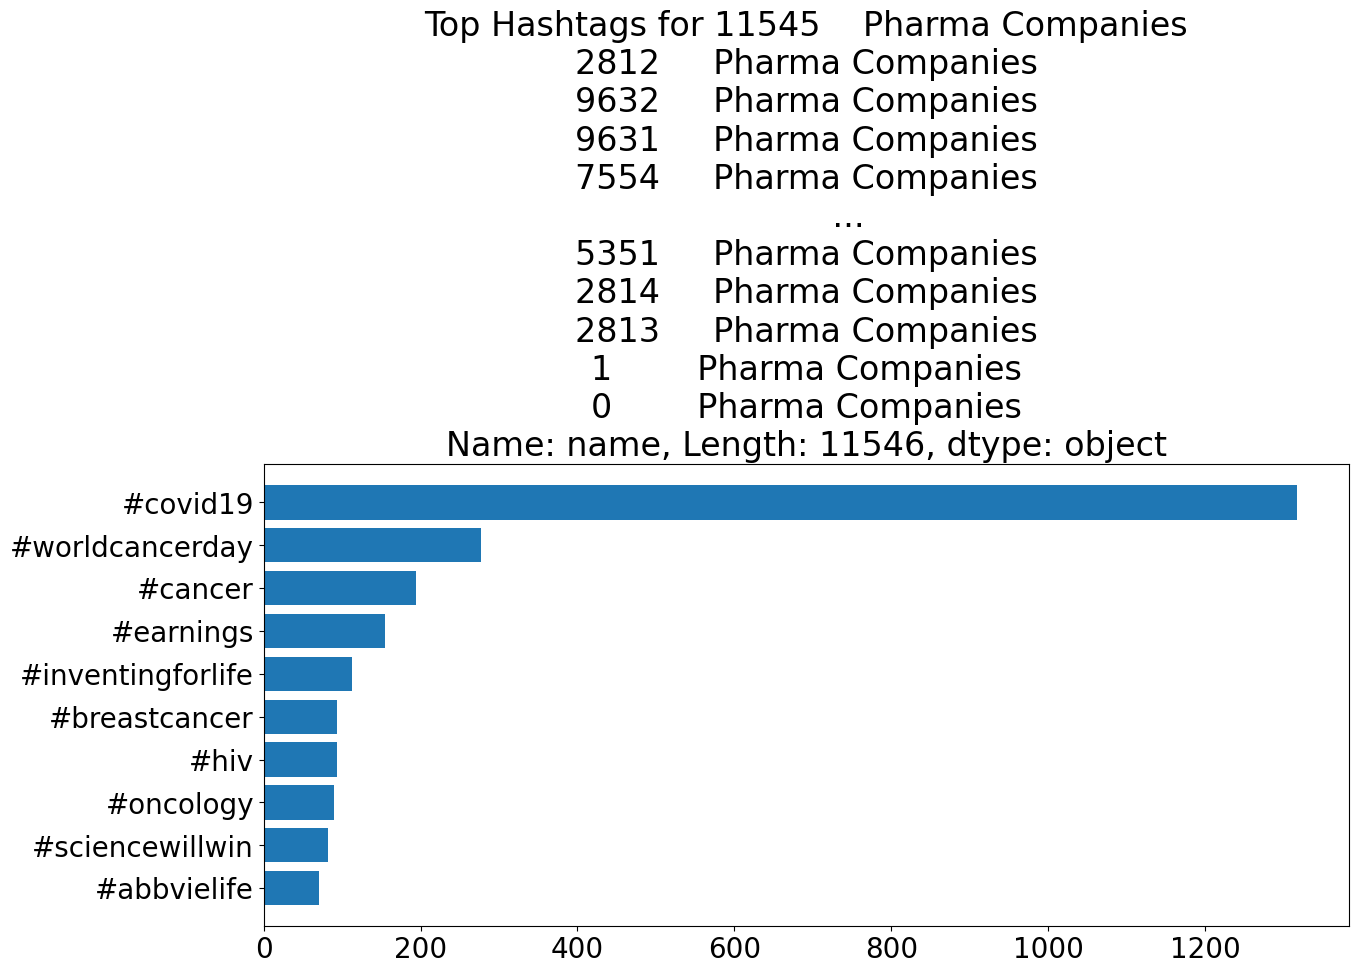

[('#covid19', 1317), ('#worldcancerday', 277), ('#cancer', 194), ('#earnings', 155), ('#inventingforlife', 113), ('#breastcancer', 94), ('#hiv', 93), ('#oncology', 90), ('#sciencewillwin', 82), ('#abbvielife', 70)]
hashtag_overview: {'num_posts': 11546, 'num_hashtags': 10330, 'hashtags_per_post': 0.8946821410012126, 'unique_hashtags': 1794}


In [ ]:
hashtags(pharma_df, 'tweet')

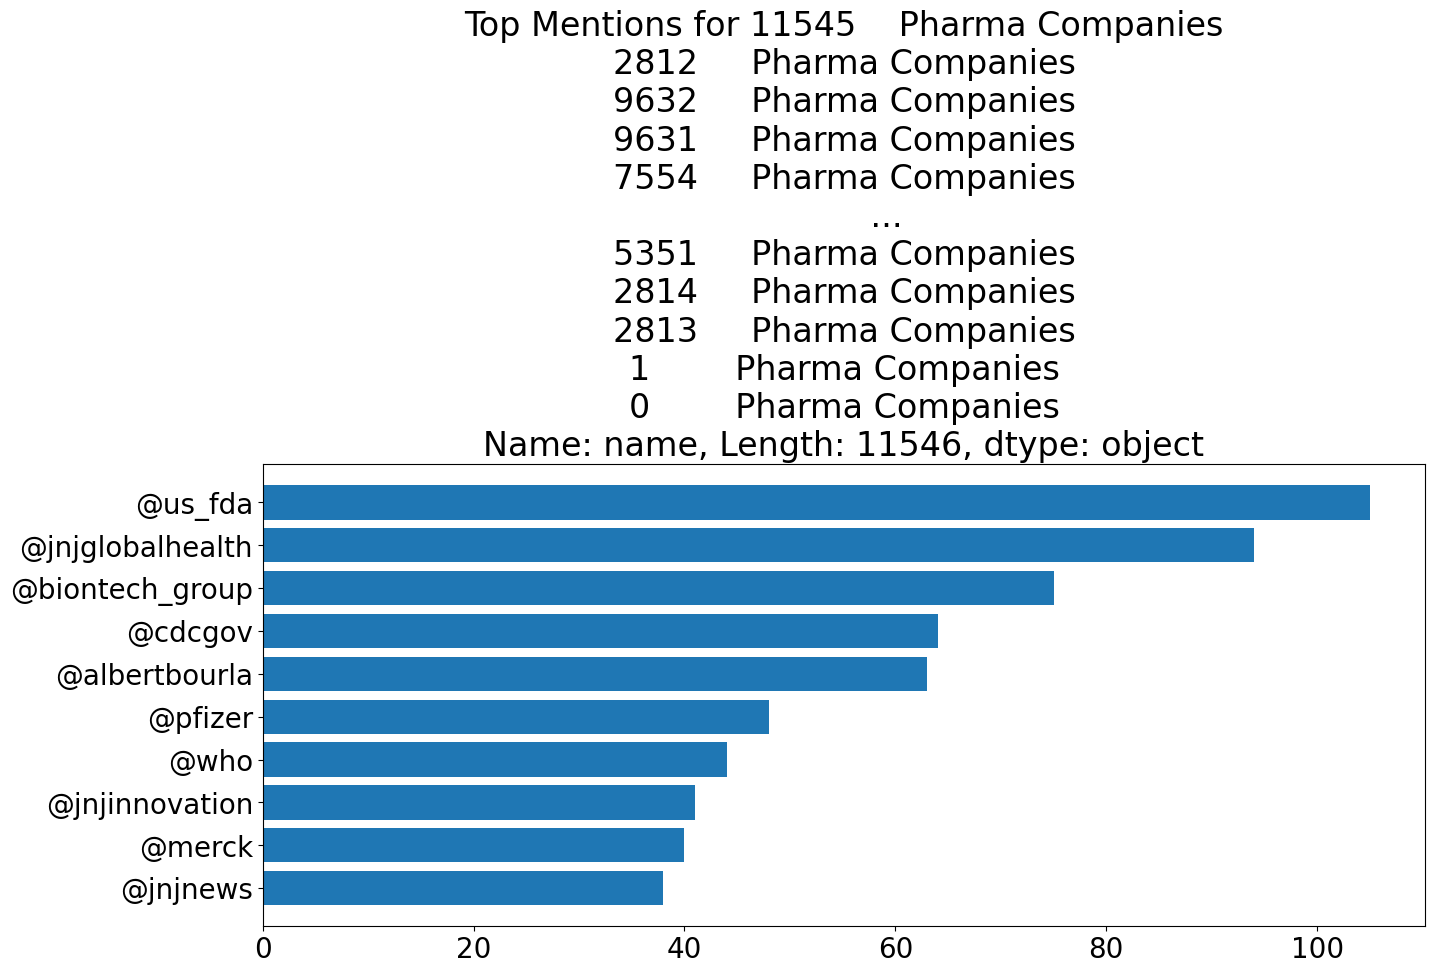

[('@us_fda', 105), ('@jnjglobalhealth', 94), ('@biontech_group', 75), ('@cdcgov', 64), ('@albertbourla', 63), ('@pfizer', 48), ('@who', 44), ('@jnjinnovation', 41), ('@merck', 40), ('@jnjnews', 38)]
overview: {'num_posts': 11546, 'num_mentions': 6725, 'mentions_per_post': 0.5824527975056296, 'unique_mentions': 3652}


In [ ]:
mentions(pharma_df,'tweet')

#Pre-processing

In [ ]:
 !pip install -qq -U mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy
from numpy.random import randint
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules
import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.algorithms.flow import shortest_augmenting_path
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
PORTER_STEMMER = PorterStemmer()

In [ ]:
pharma_username = ['pfizer']
#'JNJNews', 'AstraZeneca', 'GSK', 'Novartis'
public_username = ['CDCgov', 'IHSgov', 'GovCanHealth', 'GCIndigenous']
ngo_username = ['WHO']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Constants
file1 = '/content/drive/MyDrive/Project 2/data/pharma_companies/'+'pfizer'+'.csv'
file2 = '/content/drive/MyDrive/Project 2/data/pharma_companies/'+'Merck'+'.csv'
file3 = '/content/drive/MyDrive/Project 2/data/pharma_companies/'+'JNJNews'+'.csv'
file4 = '/content/drive/MyDrive/Project 2/data/pharma_companies/'+'LillyPad'+'.csv'
file5 = '/content/drive/MyDrive/Project 2/data/pharma_companies/'+'abbvie'+'.csv'
Sample_Tweets = pd.concat(
map(pd.read_csv, [file1, file2, file3, file4, file5]), ignore_index=True)
print(Sample_Tweets)
# dataFrame.to_csv('/content/drive/MyDrive/Project 2/gephi/public_health_agencies/public_merged.csv')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                        id                 created_at      conversation_id  \
0      1608855710695149572  2022-12-30 16:01:07+00:00  1608855710695149572   
1      1608854197776125952  2022-12-30 15:55:06+00:00  1608854197776125952   
2      1608491796086116368  2022-12-29 15:55:03+00:00  1608491796086116368   
3      1608129410070102017  2022-12-28 15:55:03+00:00  1608129410070102017   
4      1607812862314962946  2022-12-27 18:57:12+00:00  1607812862314962946   
...                    ...                        ...                  ...   
11541  1215666835309449217  2020-01-10 16:08:54+00:00  1174013759142187010   
11542  1215264519460655104  2020-01-09 13:30:14+00:00  1215264519460655104   
11543  1214970101612593159  2020-01-08 18:00:19+00:00  1214970101612593159   
11544  1214592621676564480  2020-01-07 17:00:21+00:00  1214592621676564480   
11545  1212372993952927746  2020-01-01 14:00:21+00:00  1212372993952927746   

                                                   tweet  retwe

In [ ]:
stopwords_df = set(nltk.corpus.stopwords.words("english"));
stopwords_df.add("holiday")
stopwords_df.add("abbvie")
stopwords_df.add("right")
stopwords_df.add("lilli")
print(stopwords_df)

{'whom', 'not', "it's", 'as', 'further', 'out', 'just', 'hadn', 'if', 'down', 'when', 'at', 'its', 'his', 'themselves', 'from', 'being', 'while', 'but', "shan't", 'isn', 'do', "should've", 'hers', 'own', 'you', 'itself', 've', 'on', 'holiday', 'once', 'y', 'through', 'they', 'such', 'lilli', 'against', "needn't", 'or', 'myself', 'and', 'm', "haven't", 'will', "hadn't", 'me', 'can', 'off', "she's", "don't", 'were', 'ourselves', "isn't", 'll', 'i', 'into', 'what', 'mustn', 'doing', 'mightn', 'did', 'their', 'abbvie', "you'll", 'him', 'he', 'that', "doesn't", 'her', 'too', 'aren', 'himself', "couldn't", 'other', 'shouldn', 'some', 'yourselves', 'it', 'does', 'are', 'so', 'up', 'having', 'in', 'for', 'no', 'which', 'of', 'be', 'who', 'same', 'very', "shouldn't", "wouldn't", 'haven', 'these', 'had', 'doesn', "didn't", 'over', 'has', 'don', 'ma', "won't", "that'll", 'weren', 'by', "you've", 'ain', "mightn't", 'before', "weren't", 'now', 'have', 'more', 'how', "aren't", 'we', 'your', 'ours', 

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Word Cloud

In [ ]:
df = None
Tweet_Texts=Sample_Tweets['tweet'].values

# Converting the text column as a single string for wordcloud
Tweets_String=str(Tweet_Texts)

# Tweet Text cleaning
import re

# Converting the whole text to lowercase
Tweet_Texts_Cleaned = Tweets_String.lower()

# Removing the twitter usernames from tweet string
Tweet_Texts_Cleaned=re.sub(r'@\w+', ' ', Tweet_Texts_Cleaned)

# Removing the URLS from the tweet string
Tweet_Texts_Cleaned=re.sub(r'http\S+', ' ', Tweet_Texts_Cleaned)


# Deleting everything which is not characters
Tweet_Texts_Cleaned = re.sub(r'[^a-z A-Z]', ' ',Tweet_Texts_Cleaned)

# Deleting any word which is less than 3-characters mostly those are stopwords
Tweet_Texts_Cleaned= re.sub(r'\b\w{1,2}\b', '', Tweet_Texts_Cleaned)

# Stripping extra spaces in the text
Tweet_Texts_Cleaned= re.sub(r' +', ' ', Tweet_Texts_Cleaned)

Tweet_Texts_Cleaned

' holiday feels holiday feels you can the right thing without the right culture our head tim richmond shares how acting with integrity part who are abbvie read here integrity culture wednesdaywisdom determination what keeps going search innovative solutions help patients address their unmet needs here health happiness and continued innovation happynewyear '

In [ ]:
print(Tweet_Texts_Cleaned)

 holiday feels holiday feels you can the right thing without the right culture our head tim richmond shares how acting with integrity part who are abbvie read here integrity culture wednesdaywisdom determination what keeps going search innovative solutions help patients address their unmet needs here health happiness and continued innovation happynewyear 


/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


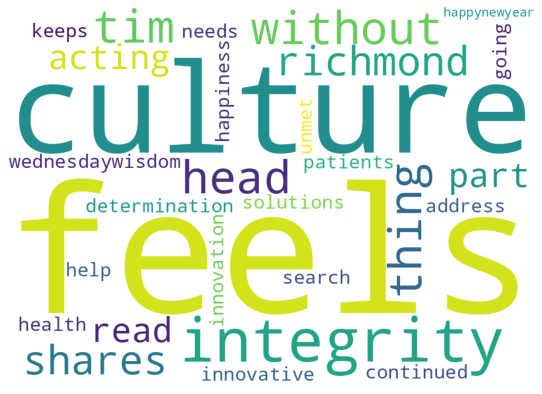

In [ ]:
# Plotting the wordcloud 
# you can specify fonts, stopwords, background color and other options
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Creating the custom stopwords
customStopwords=list(stopwords_df)

wordcloudimage = WordCloud(
                          max_words=200,
                          max_font_size=500,
                          font_step=2,
                          stopwords=customStopwords,
                          background_color='white',
                          width=1000,
                          height=720
                          ).generate(Tweet_Texts_Cleaned)

plt.figure(figsize=(15,7))
plt.axis("off")
plt.imshow(wordcloudimage)
wordcloudimage
plt.show()

#ARM (Itemsets)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def clean_tweets(x, STOPWORDS):
    # Lowercase
    sentence = x.lower()
    
    # Remove all non-alphabets (punctuation, numbers, new-line characters and extra-spaces)
    sentence = re.sub('http[s]?://\S+', '', sentence)
    sentence = re.sub(r'([^a-zA-Z ]+?)', '', sentence)
    #print(sentence)
    #sentence = sentence.replace('\n', '')
    # Remove URLs
    sentence = sentence.replace("world health organization", "who")
    #print(sentence)
    # Remove double spacing
    #sentence = re.sub('\s+', ' ', sentence)
    tokenized_tweet = [word for word in word_tokenize(sentence) if word not in STOPWORDS]
    tokenized_tweet = [PORTER_STEMMER.stem(word) for word in tokenized_tweet]
    return tokenized_tweet

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:6: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \S
<ipython-input-9-e9114ee358bb>:6: DeprecationWarning: invalid escape sequence \S
  sentence = re.sub('http[s]?://\S+', '', sentence)


In [ ]:
df = Sample_Tweets
  
#clean tweets
tqdm.pandas()
df["tokenized_tweet"] = df["tweet"].progress_apply(lambda x : clean_tweets(x, stopwords_df))
tokenized_tweets = df["tokenized_tweet"].values.tolist()
te = TransactionEncoder()
te_ary = te.fit(tokenized_tweets).transform(tokenized_tweets)
df = pd.DataFrame(te_ary, columns=te.columns_)


  

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/11546 [00:00<?, ?it/s]

In [ ]:
#Itemsets


min_sup=0.5
frequent_itemsets = apriori(df, min_support=min_sup, use_colnames=True)
print("len of frequent itemsets: ", len(frequent_itemsets.index))

while(len(frequent_itemsets.index)<100):
  min_sup = min_sup/2
  frequent_itemsets = apriori(df, min_support=min_sup, use_colnames=True)
  print("len of frequent itemsets: ", len(frequent_itemsets.index))

itemsets_df = frequent_itemsets[:100] 
print(itemsets_df)
itemsets_df.to_csv("itemsets.csv");




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


len of frequent itemsets:  0
len of frequent itemsets:  0
len of frequent itemsets:  5
len of frequent itemsets:  27
len of frequent itemsets:  71781
     support        itemsets
0   0.032219       (address)
1   0.039234        (advanc)
2   0.107310           (amp)
3   0.033778          (anim)
4   0.033431       (announc)
..       ...             ...
95  0.031526    (anim, forc)
96  0.032998    (anim, here)
97  0.032998  (anim, inform)
98  0.032998   (anim, lilli)
99  0.031526    (anim, part)

[100 rows x 2 columns]


In [ ]:
df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


aa  aaaai   aacr    aad  aadmemb  aadvmx  aafan   aaho   aaic  \
0      False  False  False  False    False   False  False  False  False   
1      False  False  False  False    False   False  False  False  False   
2      False  False  False  False    False   False  False  False  False   
3      False  False  False  False    False   False  False  False  False   
4      False  False  False  False    False   False  False  False  False   
...      ...    ...    ...    ...      ...     ...    ...    ...    ...   
11541  False  False  False  False    False   False  False  False  False   
11542  False  False  False  False    False   False  False  False  False   
11543  False  False  False  False    False   False  False  False  False   
11544  False  False  False  False    False   False  False  False  False   
11545  False  False  False  False    False   False  False  False  False   

       aaishah  ...   zona   zone  zoogandwoo   zook  zoologist  zpwlc  \
0        False  ...  False  False       False  False      False  False   
1        False  ...  False  False       False  False      False  False   
2        False  ...  False  False       False  False      False  False   
3        False  ...  False  False       False  False      False  False   
4        False  ...  False  False       False  False      False  False   
...        ...  ...    ...    ...         ...    ...        ...    ...   
11541    False  ...  False  False       False  False      False  False   
11542    False  ...  False  False       False  False      False  False   
11543    False  ...  False  False       False  False      False  False   
11544    False  ...  False  False       False  False      False  False   
11545    False  ...  False  False       False  False      False  False   

       zschiffman  zubaira  zulfkar  zyrtec  
0           False    False    False   False  
1           False    False    False   False  
2           False    False    False   False  
3           False    False    False   False  
4           False    False    False   False  
...           ...      ...      ...     ...  
11541       False    False    False   False  
11542       False    False    False   False  
11543       False    False    False   False  
11544       False    False    False   False  
11545       False    False    False   False  

[11546 rows x 12665 columns]

    Confidence  Number of rules
0          0.0               80
1          0.1               80
2          0.2               79
3          0.3               69
4          0.4               48
5          0.5               38
6          0.6               25
7          0.7               14
8          0.8                9
9          0.9                8
10         1.0                0


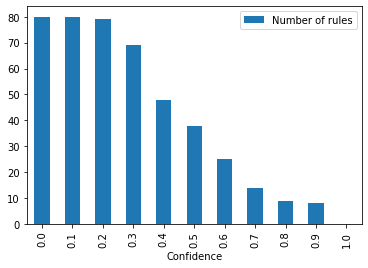

In [ ]:
frequent_itemsets2 = apriori(df, min_support=0.035, use_colnames=True)
frequent_itemsets2

confidence = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
number_of_rules = []

for i in confidence:
    a = association_rules(frequent_itemsets2, metric="confidence", min_threshold=i)
    number_of_rules.append(len(a))

data = {'Confidence': confidence, 'Number of rules': number_of_rules}
df2 = pd.DataFrame(data=data)
print(df2)
plot = df2.plot.bar(x='Confidence', y='Number of rules')

In [ ]:
association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.5)


antecedents      consequents  antecedent support  consequent support  \
0             (call)          (pleas)            0.063918            0.104538   
1           (inform)           (care)            0.083752            0.101420   
2             (test)           (care)            0.055084            0.101420   
3          (contact)          (pleas)            0.063139            0.104538   
4          (contact)          (thank)            0.063139            0.157977   
5           (vaccin)          (covid)            0.119695            0.184220   
6           (inform)          (lilli)            0.083752            0.117183   
7           (messag)         (inform)            0.062013            0.083752   
8             (test)         (inform)            0.055084            0.083752   
9           (inform)          (thank)            0.083752            0.157977   
10          (messag)          (lilli)            0.062013            0.117183   
11            (test)          (lilli)            0.055084            0.117183   
12             (use)          (lilli)            0.065910            0.117183   
13          (messag)          (thank)            0.062013            0.157977   
14            (part)       (research)            0.051793            0.092153   
15        (question)          (pleas)            0.062013            0.104538   
16           (pleas)          (thank)            0.104538            0.157977   
17           (pleas)             (us)            0.104538            0.150442   
18            (test)       (research)            0.055084            0.092153   
19             (use)       (research)            0.065910            0.092153   
20             (use)           (test)            0.065910            0.055084   
21            (test)            (use)            0.055084            0.065910   
22    (inform, care)          (lilli)            0.045817            0.117183   
23     (care, lilli)         (inform)            0.047202            0.083752   
24   (inform, lilli)           (care)            0.050320            0.101420   
25          (inform)    (care, lilli)            0.083752            0.047202   
26    (test, inform)          (lilli)            0.038108            0.117183   
27   (inform, lilli)           (test)            0.050320            0.055084   
28     (test, lilli)         (inform)            0.039494            0.083752   
29            (test)  (inform, lilli)            0.055084            0.050320   
30   (messag, thank)         (inform)            0.056210            0.083752   
31  (messag, inform)          (thank)            0.036376            0.157977   
32   (inform, thank)         (messag)            0.044518            0.062013   
33          (messag)  (inform, thank)            0.062013            0.044518   
34   (messag, thank)          (lilli)            0.056210            0.117183   
35   (messag, lilli)          (thank)            0.043738            0.157977   
36    (thank, lilli)         (messag)            0.047029            0.062013   
37          (messag)   (thank, lilli)            0.062013            0.047029   

     support  confidence       lift  leverage  conviction  
0   0.037849    0.592141   5.664341  0.031167    2.195517  
1   0.045817    0.547053   5.393912  0.037323    1.983850  
2   0.035510    0.644654   6.356256  0.029923    2.528746  
3   0.038801    0.614540   5.878612  0.032201    2.323102  
4   0.036896    0.584362   3.699038  0.026921    2.025858  
5   0.066863    0.558611   3.032308  0.044813    1.848211  
6   0.050320    0.600827   5.127237  0.040506    2.211616  
7   0.036376    0.586592   7.003923  0.031183    2.216330  
8   0.038108    0.691824   8.260392  0.033495    2.973131  
9   0.044518    0.531541   3.364677  0.031287    1.797431  
10  0.043738    0.705307   6.018830  0.036471    2.995719  
11  0.039494    0.716981   6.118451  0.033039    3.119285  
12  0.037329    0.566360   4.833107  0.029605    2.035828  
13  0.056

#ARM (Rules)

In [ ]:
matrix_df = pd.DataFrame(columns=['Threshold Support', 'Threshold Confidence', 'Count of rules'])
for min_support_initialize in np.arange(0.035, 0.4, 0.002): #0.125, 0.5, 0.0625
  for min_threshold_initialize in np.arange(0.5, 1, 0.1):
    frequent_itemsets_temp = apriori(df, min_support=min_support_initialize, use_colnames=True)
    if(frequent_itemsets_temp.empty):
      continue
    rules = association_rules(frequent_itemsets_temp, metric="confidence", min_threshold=min_threshold_initialize)
  # rules = rules.sort_values(by='confidence', ascending =False)
  # print(rules)
    matrix_df.loc[len(matrix_df.index)] = [min_support_initialize, min_threshold_initialize, len(rules.index)] 
  
print(matrix_df)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     Threshold Support  Threshold Confidence  Count of rules
0                0.035                   0.5            38.0
1                0.035                   0.6            25.0
2                0.035                   0.7            14.0
3                0.035                   0.8             9.0
4                0.035                   0.9             8.0
..                 ...                   ...             ...
475              0.225                   0.5             0.0
476              0.225                   0.6             0.0
477              0.225                   0.7             0.0
478              0.225                   0.8             0.0
479              0.225                   0.9             0.0

[480 rows x 3 columns]


In [ ]:
matrix_df.to_csv('Support vs Confidence for WHO.csv')

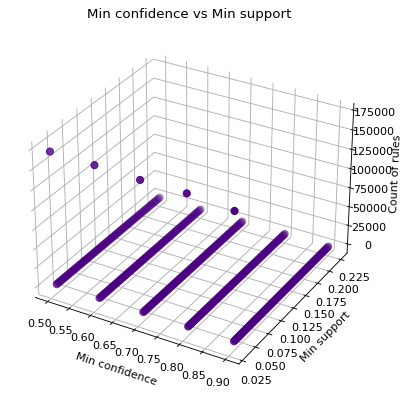

In [ ]:
from IPython.core.pylabtools import figsize
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import itertools
fig = plt.figure(figsize=(8, 6), dpi=80)

# syntax for 3-D projection
ax = plt.axes(projection ='3d', )

# defining all 3 axes
z = matrix_df['Count of rules']
x = matrix_df['Threshold Confidence']
y = matrix_df['Threshold Support']

# plotting

ax.scatter(x, y, z, color='indigo', s=40)
ax.set_title('Min confidence vs Min support')
ax.set_xlabel('Min confidence')
ax.set_ylabel('Min support')

# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# ax.grid(False)

ax.set_zlabel('Count of rules')
plt.show()


In [ ]:
# 0              0.1250                   0.5           101.0

# 4              0.01                   0.8         0
frequent_itemsets_temp = apriori(df, min_support=0.034, use_colnames=True)

rules = association_rules(frequent_itemsets_temp, metric="confidence", min_threshold=0.5)
rules[rules['lift']>=1]
print(rules)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


          antecedents                   consequents  antecedent support  \
0              (call)                       (pleas)            0.063918   
1            (inform)                        (care)            0.083752   
2              (test)                        (care)            0.055084   
3               (use)                        (care)            0.065910   
4           (contact)                       (pleas)            0.063139   
..                ...                           ...                 ...   
273  (part, research)            (swim, forc, test)            0.035683   
274            (swim)  (forc, part, test, research)            0.034731   
275            (forc)  (swim, part, test, research)            0.038368   
276            (test)  (swim, forc, part, research)            0.055084   
277            (part)  (swim, forc, test, research)            0.051793   

     consequent support   support  confidence       lift  leverage  conviction  
0              0.1

In [ ]:
rules.to_csv('/content/drive/MyDrive/Project 2/results/pharma/'+'pharma'+'.csv')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
type(rules)

pandas.core.frame.DataFrame

In [ ]:
df1 = (rules.explode('antecedents')
         .reset_index(drop=True)
         .explode('consequents')
         .reset_index(drop=True))
df1.to_csv('WHO rules.csv')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Metrics
Recommender systems can also profit from the messages shared on social media 

The higher the popularity of a tweet, the more likely it is to contain highly supported association rule.




In [ ]:
Sample_Tweets['Tweet_popularity'] = Sample_Tweets['retweet_count']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Sample_Tweets = Sample_Tweets.sort_values(by=['Tweet_popularity'], ascending=False)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Sample_Tweets["tokenized_tweet"] = Sample_Tweets["tweet"].progress_apply(lambda x : clean_tweets(x, stopwords_df))


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/11546 [00:00<?, ?it/s]

In [ ]:
Sample_Tweets

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id                 created_at      conversation_id  \
1870  1325767629890592771  2020-11-09 11:50:09+00:00  1325767629890592771   
3879  1366900591570649095  2021-03-02 23:57:51+00:00  1366900591570649095   
6503  1367134717871599619  2021-03-03 15:28:11+00:00  1367134717871599619   
642   1493238623633870850  2022-02-14 15:00:05+00:00  1493238623633870850   
1832  1329032586421805056  2020-11-18 12:03:55+00:00  1329032586421805056   
...                   ...                        ...                  ...   
3042  1534286438774321153  2022-06-07 21:29:27+00:00  1534286438774321153   
3041  1534287217492955136  2022-06-07 21:32:32+00:00  1534287217492955136   
627   1499451137984024577  2022-03-03 18:26:24+00:00  1499101129288093697   
631   1496509887530127362  2022-02-23 15:38:55+00:00  1496509887530127362   
5773  1453876611573559303  2021-10-29 00:09:30+00:00  1453494029296013314   

                                                  tweet  retweet_count  \
1870  UPDATE: We are proud to announce, along with @...          11470   
3879  RT @WhiteHouse: Today, President Biden announc...           5473   
6503  RT @WhiteHouse: Today, President Biden announc...           5473   
642   Deep vein thrombosis (#DVT), a blood clot in a...           4137   
1832  BREAKING: We are proud to announce, along with...           3262   
...                                                 ...            ...   
3042  When our colleague Scott shared his story of c...              0   
3041  When our colleague Scott shared his story of c...              0   
627   @SawyerHair Thank you for reaching out. To con...              0   
631   People living with a #raredisease represent on...              0   
5773  @Kaceydian Thanks for letting us know. Please ...              0   

      like_count  reply_count  quote_count  \
1870       33785         1356         6519   
3879           0            0            0   
6503           0            0            0   
642         3659         2795         4665   
1832       11380          515         1445   
...          ...          ...          ...   
3042           0            0            0   
3041           0            0            0   
627            1            1            1   
631            4            3            1   
5773           1            0            0   

                                           expanded_url language  \
1870                                                NaN       en   
3879                                                NaN       en   
6503                                                NaN       en   
642                                                 NaN       en   
1832                                                NaN       en   
...                                                 ...      ...   
3042                                                NaN       en   
3041                                                NaN       en   
627                      https://www.pfizer.com/contact       en   
631   https://twitter.com/pfizer/status/149650988753...       en   
5773             https://vaers.hhs.gov/reportevent.html       en   

      possibly_sensitive  in_reply_to_user_id username  \
1870               False                  NaN   pfizer   
3879               False                  NaN    Merck   
6503               False                  NaN  JNJNews   
642                False                  NaN   pfizer   
1832               False                  NaN   pfizer   
...                  ...                  ...      ...   
3042               False                  NaN    Merck   
3041               False                  NaN    Merck   
627                False         1.393158e+18   pfizer   
631                False                  NaN   pfizer   
5773               False         1.245414e+18  JNJNews   

                                        tokenized_tweet  Tweet_popularity  
1870  [updat, proud, announc, along, biontechgroup, ...           

In [ ]:
Sample_Tweets["tokenized_tweet"]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1870    [updat, proud, announc, along, biontechgroup, ...
3879    [rt, whitehous, today, presid, biden, announc,...
6503    [rt, whitehous, today, presid, biden, announc,...
642     [deep, vein, thrombosi, dvt, blood, clot, deep...
1832    [break, proud, announc, along, biontechgroup, ...
                              ...                        
3042    [colleagu, scott, share, stori, come, midlif, ...
3041    [colleagu, scott, share, stori, come, midlif, ...
627     [sawyerhair, thank, reach, contact, us, direct...
631     [peopl, live, rarediseas, repres, one, largest...
5773    [kaceydian, thank, let, us, know, pleas, repor...
Name: tokenized_tweet, Length: 11546, dtype: object

In [ ]:
type(Sample_Tweets['tokenized_tweet'])

pandas.core.series.Series

In [ ]:
sorted_df = Sample_Tweets['tokenized_tweet']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sorted_df.to_csv('sorted.csv')

In [ ]:
Sample_Tweets.iloc[0]['tweet']

'UPDATE: We are proud to announce, along with @BioNTech_Group, that our mRNA-based #vaccine candidate has, at an interim analysis, demonstrated initial evidence of efficacy against #COVID19 in participants without prior evidence of SARS-CoV-2 infection.'

In [ ]:
rules['rank'] = rules['antecedent support']+rules['confidence']+rules['consequent support']+rules['leverage']+rules['lift']+rules['support']+rules['conviction']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sorted_rules = rules.sort_values(by=['rank'], ascending=False)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sorted_rules

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


antecedents             consequents  antecedent support  \
139        (swim, research)                  (part)            0.034731   
226  (forc, research, test)                  (swim)            0.034731   
141                  (swim)        (part, research)            0.034731   
219                  (swim)      (forc, part, test)            0.034731   
193                  (swim)  (forc, part, research)            0.034731   
..                      ...                     ...                 ...   
55                  (pleas)                    (us)            0.104538   
26                 (inform)                 (thank)            0.083752   
54                  (pleas)                 (thank)            0.104538   
67                    (use)                 (thank)            0.065910   
6                  (vaccin)                 (covid)            0.119695   

     consequent support   support  confidence       lift  leverage  \
139            0.051793  0.034731    1.000000  19.307692  0.032932   
226            0.034731  0.034731    1.000000  28.793017  0.033524   
141            0.035683  0.034731    1.000000  28.024272  0.033491   
219            0.034731  0.034731    1.000000  28.793017  0.033524   
193            0.034731  0.034731    1.000000  28.793017  0.033524   
..                  ...       ...         ...        ...       ...   
55             0.150442  0.053698    0.513670   3.414414  0.037971   
26             0.157977  0.044518    0.531541   3.364677  0.031287   
54             0.157977  0.054824    0.524441   3.319733  0.038310   
67             0.157977  0.034644    0.525624   3.327224  0.024232   
6              0.184220  0.066863    0.558611   3.032308  0.044813   

     conviction      rank  
139         inf       inf  
226         inf       inf  
141         inf       inf  
219         inf       inf  
193         inf       inf  
..          ...       ...  
55     1.746877  6.021611  
26     1.797431  6.011182  
54     1.770596  5.970419  
67     1.775013  5.910624  
6      1.848211  5.854720  

[278 rows x 10 columns]

In [ ]:
type(sorted_rules['antecedents'])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


pandas.core.series.Series

#Accuracy

Compare sorted_rules['antecedents']+sorted_rules['consequents]' with Sample_tweets['tokenized_tweet'] using iloc

In [ ]:
type(list(sorted_rules.iloc[0]['antecedents']))

list

In [ ]:
count=0
l1 = list(sorted_rules.iloc[0]['antecedents'])
for value in l1:
  if value in sorted_df.iloc[0]:
    count=count+1
l2 = list(sorted_rules.iloc[0]['consequents'])
if(count==len(l1)):
  for value in l2:
    if value in sorted_df.iloc[0]:
      count=count+1
if(count==len(l1)+len(l2)):
  print("exists")
else:
  print("does not exist")

does not exist


In [ ]:
len(sorted_rules.index)

38

In [ ]:
len(sorted_df.index)

11546

In [ ]:
sorted_df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1870    [updat, proud, announc, along, biontechgroup, ...
3879    [rt, whitehous, today, presid, biden, announc,...
6503    [rt, whitehous, today, presid, biden, announc,...
642     [deep, vein, thrombosi, dvt, blood, clot, deep...
1832    [break, proud, announc, along, biontechgroup, ...
                              ...                        
3042    [colleagu, scott, share, stori, come, midlif, ...
3041    [colleagu, scott, share, stori, come, midlif, ...
627     [sawyerhair, thank, reach, contact, us, direct...
631     [peopl, live, rarediseas, repres, one, largest...
5773    [kaceydian, thank, let, us, know, pleas, repor...
Name: tokenized_tweet, Length: 11546, dtype: object

In [ ]:
counter=0

save_df = pd.DataFrame(columns=['Tweet ID (iloc)', 'tweet', 'tokenized', 'Rule No.', 'rule', 'Username'])
# matrix_df.loc[len(matrix_df.index)] = [min_support_initialize, min_threshold_initialize, len(rules.index)] 
for i in range (0, 5000, 1): #data
  for j in range(0, 38, 1): #rules
    count=0
    l1 = list(sorted_rules.iloc[j]['antecedents'])
    for value in l1:
      if value in sorted_df.iloc[i]:
        count=count+1
    l2 = list(sorted_rules.iloc[j]['consequents'])
    if(count==len(l1)):
      for value in l2:
        if value in sorted_df.iloc[i]:
          count=count+1
    if(count==len(l1)+len(l2)):
      save_df.loc[len(save_df.index)] = [i, Sample_Tweets.iloc[i]['tweet'], Sample_Tweets.iloc[i]["tokenized_tweet"], j, list(sorted_rules.iloc[j]['antecedents'])+list(sorted_rules.iloc[j]['consequents']), Sample_Tweets.iloc[i]['username']]
      # print("Tweet ", i, " contains rule number ", j)
      counter=counter+1 


In [ ]:
save_df

Tweet ID (iloc)                                              tweet  \
0                  0  UPDATE: We are proud to announce, along with @...   
1                  4  BREAKING: We are proud to announce, along with...   
2                  7  While vaccines may prevent COVID-19, monoclona...   
3                  8  Before many people had even heard of #COVID19,...   
4                 10  #JNJ is working tirelessly to develop a vaccin...   
..               ...                                                ...   
708             4970  @Atticus02515588 The U.S. government has commi...   
709             4970  @Atticus02515588 The U.S. government has commi...   
710             4970  @Atticus02515588 The U.S. government has commi...   
711             4970  @Atticus02515588 The U.S. government has commi...   
712             4991  Part of creating medicines is investing in wha...   

                                             tokenized  Rule No.  \
0    [updat, proud, announc, along, biontechgroup, ...        37   
1    [break, proud, announc, along, biontechgroup, ...        37   
2    [vaccin, may, prevent, covid, monoclon, antibo...        37   
3    [mani, peopl, even, heard, covid, janssenglob,...        37   
4    [jnj, work, tirelessli, develop, vaccin, meet,...        37   
..                                                 ...       ...   
708  [atticu, us, govern, commit, american, outofpo...        11   
709  [atticu, us, govern, commit, american, outofpo...        14   
710  [atticu, us, govern, commit, american, outofpo...        30   
711  [atticu, us, govern, commit, american, outofpo...        31   
712  [part, creat, medicin, invest, what, come, con...        18   

                      rule  Username  
0          [vaccin, covid]    pfizer  
1          [vaccin, covid]    pfizer  
2          [vaccin, covid]  LillyPad  
3          [vaccin, covid]   JNJNews  
4          [vaccin, covid]   JNJNews  
..                     ...       ...  
708  [inform, lilli, care]  LillyPad  
709  [inform, care, lilli]  LillyPad  
710        [inform, lilli]  LillyPad  
711         [inform, care]  LillyPad  
712       [part, research]  LillyPad  

[713 rows x 6 columns]

In [ ]:
counter

713

In [ ]:
save_df.to_csv('/content/drive/MyDrive/Project 2/results/final pharma.csv')

In [ ]:
counter_0to20=0
counter_21to40=0
counter_41to60=0
counter_61to80=0
counter_81to100=0
counter_remaining=0
x=0
i=0
for index, row in save_df.iterrows():
  if(row['Tweet ID (iloc)'])<=1000:
    counter_0to20=counter_0to20+1
  elif(row['Tweet ID (iloc)'])<=2000:
    counter_21to40=counter_21to40+1
  elif(row['Tweet ID (iloc)'])<=300:
    counter_41to60=counter_41to60+1
  elif(row['Tweet ID (iloc)'])<=4000:
    counter_61to80=counter_61to80+1
  else: 
    x=x+1

In [ ]:
print(counter_0to20, " ", counter_21to40, " ", counter_41to60, " ", counter_61to80, " ", x)

304   190   0   171   48


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lim = ['500', '1000', '1500', '2000', '2500']
val = [counter_0to20,counter_21to40,counter_41to60,counter_61to80,x]
ax.bar(lim,val, color = 'orange')
plt.show()

# CausalNLP

In [39]:
!pip install -q causalnlp

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
counter=0

causal_df = pd.DataFrame(columns=['Tweet ID (iloc)', 'tweet_text', 'tokenized', 'Rule No.', 'rule', 'Username', 'Is_RulePresent?', 'Is_TweetPopular?'])
# matrix_df.loc[len(matrix_df.index)] = [min_support_initialize, min_threshold_initialize, len(rules.index)] 
for i in range (0, 115, 1): #data
  for j in range(0, 277, 1): #rules
    count=0
    is_rule_there=0
    l1 = list(sorted_rules.iloc[j]['antecedents'])
    for value in l1:
      if value in sorted_df.iloc[i]:
        count=count+1
    l2 = list(sorted_rules.iloc[j]['consequents'])
    if(count==len(l1)):
      for value in l2:
        if value in sorted_df.iloc[i]:
          count=count+1
    if(count==len(l1)+len(l2)):
      is_rule_there=1
      is_popular=1
      causal_df.loc[len(causal_df.index)] = [i, Sample_Tweets.iloc[i]['tweet'], Sample_Tweets.iloc[i]["tokenized_tweet"], j, list(sorted_rules.iloc[j]['antecedents'])+list(sorted_rules.iloc[j]['consequents']), Sample_Tweets.iloc[i]['username'], is_rule_there, is_popular]
      # print("Tweet ", i, " contains rule number ", j)
      counter=counter+1 
    else:
      is_rule_there=0
      is_popular=1
      causal_df.loc[len(causal_df.index)] = [i, Sample_Tweets.iloc[i]['tweet'], Sample_Tweets.iloc[i]["tokenized_tweet"], j, list(sorted_rules.iloc[j]['antecedents'])+list(sorted_rules.iloc[j]['consequents']), Sample_Tweets.iloc[i]['username'], is_rule_there, is_popular]
      


for i in range (11431, 11546, 1): #data
  for j in range(0, 277, 1): #rules
    count=0
    is_rule_there=0
    l1 = list(sorted_rules.iloc[j]['antecedents'])
    for value in l1:
      if value in sorted_df.iloc[i]:
        count=count+1
    l2 = list(sorted_rules.iloc[j]['consequents'])
    if(count==len(l1)):
      for value in l2:
        if value in sorted_df.iloc[i]:
          count=count+1
    if(count==len(l1)+len(l2)):
      is_rule_there=1
      is_popular=0
      causal_df.loc[len(causal_df.index)] = [i, Sample_Tweets.iloc[i]['tweet'], Sample_Tweets.iloc[i]["tokenized_tweet"], j, list(sorted_rules.iloc[j]['antecedents'])+list(sorted_rules.iloc[j]['consequents']), Sample_Tweets.iloc[i]['username'], is_rule_there, is_popular]
      # print("Tweet ", i, " contains rule number ", j)
      counter=counter+1 
    else:
      is_rule_there=0
      is_popular=0
      causal_df.loc[len(causal_df.index)] = [i, Sample_Tweets.iloc[i]['tweet'], Sample_Tweets.iloc[i]["tokenized_tweet"], j, list(sorted_rules.iloc[j]['antecedents'])+list(sorted_rules.iloc[j]['consequents']), Sample_Tweets.iloc[i]['username'], is_rule_there, is_popular]
     

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
causal_df.to_csv('causal_df.csv')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
import causalnlp
from causalnlp import CausalInferenceModel
from lightgbm import LGBMClassifier


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
from causalnlp import CausalInferenceModel
from lightgbm import LGBMClassifier
cm = CausalInferenceModel(df, method = 't-learner',
                              treatment_col='Is_RulePresent?',
                              outcome_col='Is_TweetPopular?',
                              ignore_cols=['Tweet ID (iloc)', 'tokenized', 'Rule No.', 'Unnamed: 0', 'Username', 'tweet_text'],
                            )

cm.fit()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: ignored

In [ ]:
cm.estimate_ate()